CA7

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import copy
import argparse
import torch.nn as nn
import torch
import torch.nn.functional as F
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os

In [ ]:
data_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = data_mnist.drop('digit', axis=1).values # get just pixels
y = data_mnist['digit'].values

In [ ]:
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

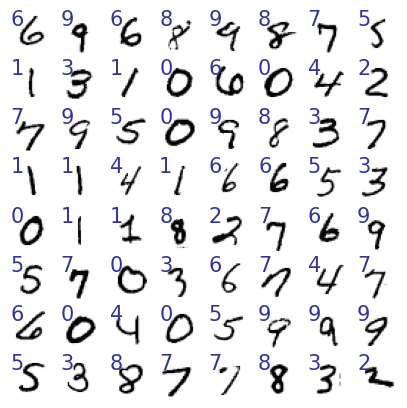

In [ ]:
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

In [ ]:
device = torch.device('cpu')
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

1. SGD Train

In [ ]:
def sgdtrain(model, X_train, y_train, X_test, y_test, 
             learning_rate = .0001, nepochs=2000, batch_size=32):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # Computing metrics in a no_grad() block is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        

        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

In [ ]:

model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) 
     

In [ ]:
#time

history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .03, nepochs=1000,
                     batch_size=len(X_train) # perform batch not mini-batch gradient descent
                  )

Epoch    0 cross entropy loss  2.3032   test loss  2.1744
Epoch  100 cross entropy loss  1.4864   test loss  1.5059
Epoch  200 cross entropy loss  1.4816   test loss  1.5040
Epoch  300 cross entropy loss  1.4803   test loss  1.5029
Epoch  400 cross entropy loss  1.4800   test loss  1.5018
Epoch  500 cross entropy loss  1.4788   test loss  1.5024
Epoch  600 cross entropy loss  1.4781   test loss  1.5015
Epoch  700 cross entropy loss  1.4780   test loss  1.5017
Epoch  800 cross entropy loss  1.4766   test loss  1.5013
Epoch  900 cross entropy loss  1.4765   test loss  1.5002
Epoch 1000 cross entropy loss  1.4757   test loss  1.4988
BEST test cross entropy loss 1.499 at epoch 992


In [ ]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)   
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")

In [ ]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.985


In [ ]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.963


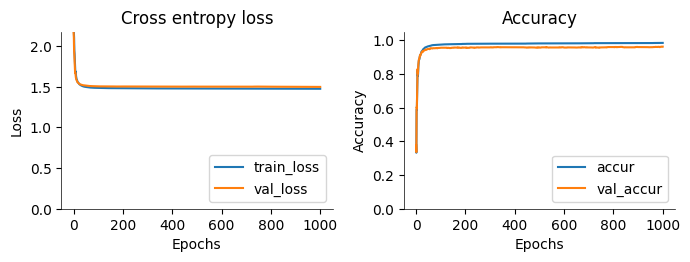

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

2.1 Minibatch Train with constant step size




In [ ]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) 


history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .001, # small learning rate due to imprecise gradients
                     nepochs=50,           # very few iterations for speed
                     batch_size=8          # very small batch size
                  )

Epoch    0 cross entropy loss  1.5945   test loss  1.5600
Epoch    5 cross entropy loss  1.7110   test loss  1.5151
Epoch   10 cross entropy loss  1.4615   test loss  1.5110
Epoch   15 cross entropy loss  1.4618   test loss  1.5023
Epoch   20 cross entropy loss  1.4612   test loss  1.5026
Epoch   25 cross entropy loss  1.5862   test loss  1.4999
Epoch   30 cross entropy loss  1.4619   test loss  1.4998
Epoch   35 cross entropy loss  1.4612   test loss  1.4974
Epoch   40 cross entropy loss  1.4612   test loss  1.4973
Epoch   45 cross entropy loss  1.4612   test loss  1.4983
Epoch   50 cross entropy loss  1.4612   test loss  1.4987
BEST test cross entropy loss 1.496 at epoch 42


In [ ]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Training accuracy 0.985
Validation accuracy 0.964


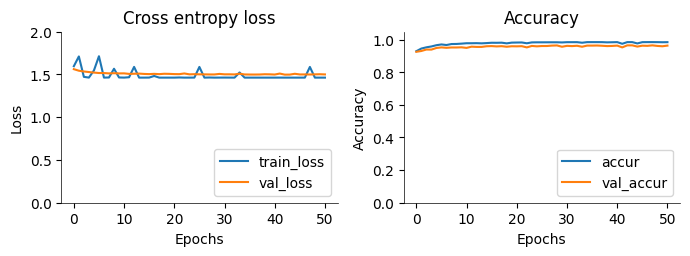

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0], maxy=2)
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

2.2 Minibatch Train with dinimishing step size $\eta_t = \eta_0/\sqrt{t}$

In [ ]:
def sgdtrain_diminish(model, X_train, y_train, X_test, y_test, 
             learning_eta = .001, nepochs=2000, batch_size=32):
    n = len(X_train)
    nbatches = n // batch_size
    
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_eta/(pow(epoch+1,0.5)))
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # Computing metrics in a no_grad() block is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        

        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) 


history,_ = sgdtrain_diminish(model, X_train, y_train, X_test, y_test,
                     learning_eta = .01, # diminishing step size
                     nepochs=50,           
                     batch_size=8          
                  )

Epoch    0 cross entropy loss  1.4733   test loss  1.5713
Epoch    5 cross entropy loss  1.7106   test loss  1.5243
Epoch   10 cross entropy loss  1.4612   test loss  1.5056
Epoch   15 cross entropy loss  1.7083   test loss  1.5052
Epoch   20 cross entropy loss  1.4612   test loss  1.4987
Epoch   25 cross entropy loss  1.4612   test loss  1.5011
Epoch   30 cross entropy loss  1.4612   test loss  1.5046
Epoch   35 cross entropy loss  1.4612   test loss  1.4963
Epoch   40 cross entropy loss  1.4612   test loss  1.4963
Epoch   45 cross entropy loss  1.4612   test loss  1.4981
Epoch   50 cross entropy loss  1.4612   test loss  1.4947
BEST test cross entropy loss 1.493 at epoch 42


In [ ]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Training accuracy 0.988
Validation accuracy 0.966


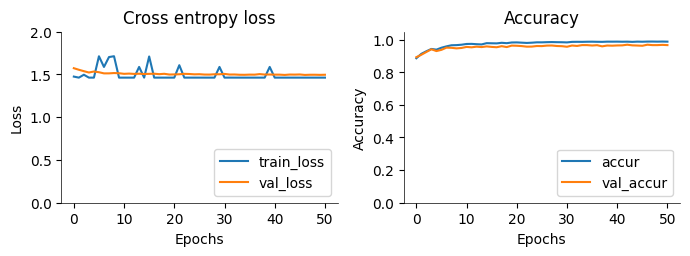

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0], maxy=2)
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

3. $L_1$ Regularization to promote sparse solutions

In [ ]:
def sgdtrain_L1(model, X_train, y_train, X_test, y_test, 
             learning_rate = .0001, nepochs=2000, batch_size=32, weight_decay=0.0, l1_lambda=0.0):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)

            # Assume model yields softmax probabilities
            l1_regularization_loss = torch.tensor(0).float()
            cross_entropy_loss = F.cross_entropy(y_pred, batch_y)
            for param in model.parameters():
                l1_regularization_loss += torch.norm(param, 1)**2
            l1_regularization_loss *= l1_lambda
            loss = cross_entropy_loss + l1_regularization_loss

            # loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # Computing metrics in a no_grad() block is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    # nn.Linear(100, 50),  # 10 output classes (0-9)
    # nn.ReLU(),
    nn.Linear(300, 300),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Linear(300, 100),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [ ]:

history,_ = sgdtrain_L1(model, X_train, y_train, X_test, y_test,
                     learning_rate = 1e-4, # small learning rate due to imprecise gradients
                     nepochs = 40,           # very few iterations for speed
                     batch_size = 8,          # very small batch size
                     l1_lambda = 0.0,
                     weight_decay = 0.0,
                  )

Epoch    0 cross entropy loss  1.6423   test loss  1.6745
Epoch    4 cross entropy loss  1.4613   test loss  1.5360
Epoch    8 cross entropy loss  1.4651   test loss  1.5202
Epoch   12 cross entropy loss  1.4612   test loss  1.5147
Epoch   16 cross entropy loss  1.4672   test loss  1.5093
Epoch   20 cross entropy loss  1.4625   test loss  1.5082
Epoch   24 cross entropy loss  1.4696   test loss  1.5042
Epoch   28 cross entropy loss  1.4612   test loss  1.5084
Epoch   32 cross entropy loss  1.4612   test loss  1.5018
Epoch   36 cross entropy loss  1.4612   test loss  1.4998
Epoch   40 cross entropy loss  1.4612   test loss  1.4994
BEST test cross entropy loss 1.498 at epoch 38


In [ ]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Training accuracy 0.981
Validation accuracy 0.962


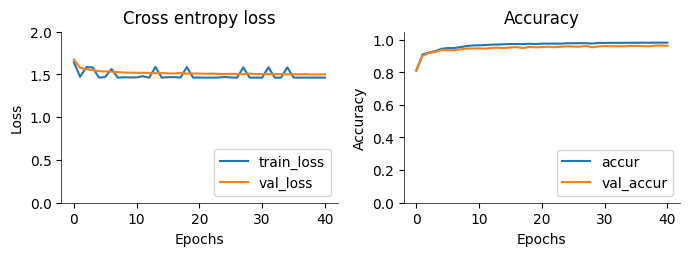

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0], maxy=2)
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()